In [2]:
import sys
sys.path.append("../../src")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helper import result_handler
import os
from utils.plot_functions import set_style, set_size
import pathlib
os.chdir("../..")
os.getcwd()

'c:\\Users\\jonas\\OneDrive - Danmarks Tekniske Universitet\\KID\\7. Semester\\Bachelor Projekt\\Sound_Classification_using_AL'

### A few smart functions for dataframe management

In [3]:
def find_csv(search_folder):
    files = []

    for (dirpath, dirnames, filenames) in os.walk(search_folder):
        for f in filenames:
            if (pathlib.Path(f).suffix == ".csv") and (f != "df.csv"):
                files.append(os.path.join(dirpath, f))

    return files


def concat_results(paths_to_dfs: list, save_path: str = None):
    df = None
    for path in paths_to_dfs:
        # Apparantly pandas prefer speed over precision:
        # https://stackoverflow.com/questions/47368296/pandas-read-csv-file-with-float-values-results-in-weird-rounding-and-decimal-dig
        new_df = pd.read_csv(path, index_col=0, float_precision="high")
        df = result_handler(df, new_df)

    if save_path:
        df.to_csv(os.path.join(save_path, "results.csv"))
    return df


def add_last_and_best(df, save_path: str = False):
    # Ensure last_model is assigned due to earlier errors
    df["last_model"] = False * len(df)
    for i in range(1, len(df)):
        if df.loc[i, "epoch"] == 1:
            df.loc[i - 1, "last_model"] = True
    df.loc[len(df) - 1, "last_model"] = True

    # Look at best model. Note that the next sampled are using the last model
    df["best_model"] = False * len(df)
    intervals = [-1] + df.index[df["last_model"] == True].tolist()
    for i in range(len(intervals) - 1):
        start = intervals[i] + 1
        end = intervals[i + 1] + 1
        df.best_model[df.test_acc[start:end].idxmax()] = True
    if save_path:
        df.to_csv(os.path.join(save_path, "results.csv"))
    return df

In [8]:
path = "/zhome/e3/3/139772/Desktop/Bachelorproject/docs/results/MobileNet/runs/MN_UR_n0_pt3.csv"
run = pd.read_csv(path)
run = run.drop(run[run["train_size"] > 1000].index)
run.to_csv("/zhome/e3/3/139772/Desktop/Bachelorproject/docs/results/MobileNet/runs/MN_UR_n0_pt3_alt.csv")

In [19]:
run = pd.read_csv("/zhome/e3/3/139772/Desktop/Bachelorproject/docs/results/MobileNet/runs/MN_200_Uncertainty & Random.csv")

run["ActiveLearn"] = "Uncertain+Random"

run.to_csv("/zhome/e3/3/139772/Desktop/Bachelorproject/docs/results/MobileNet/runs/MN_200_Uncertainty & Random_alt.csv")

C:\Users\jonas\AppData\Local\Temp\ipykernel_36520\1661199313.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.best_model[df.test_acc[start:end].idxmax()] = True
C:\Users\jonas\AppData\Local\Temp\ipykernel_36520\1661199313.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.best_model[df.test_acc[start:end].idxmax()] = True
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


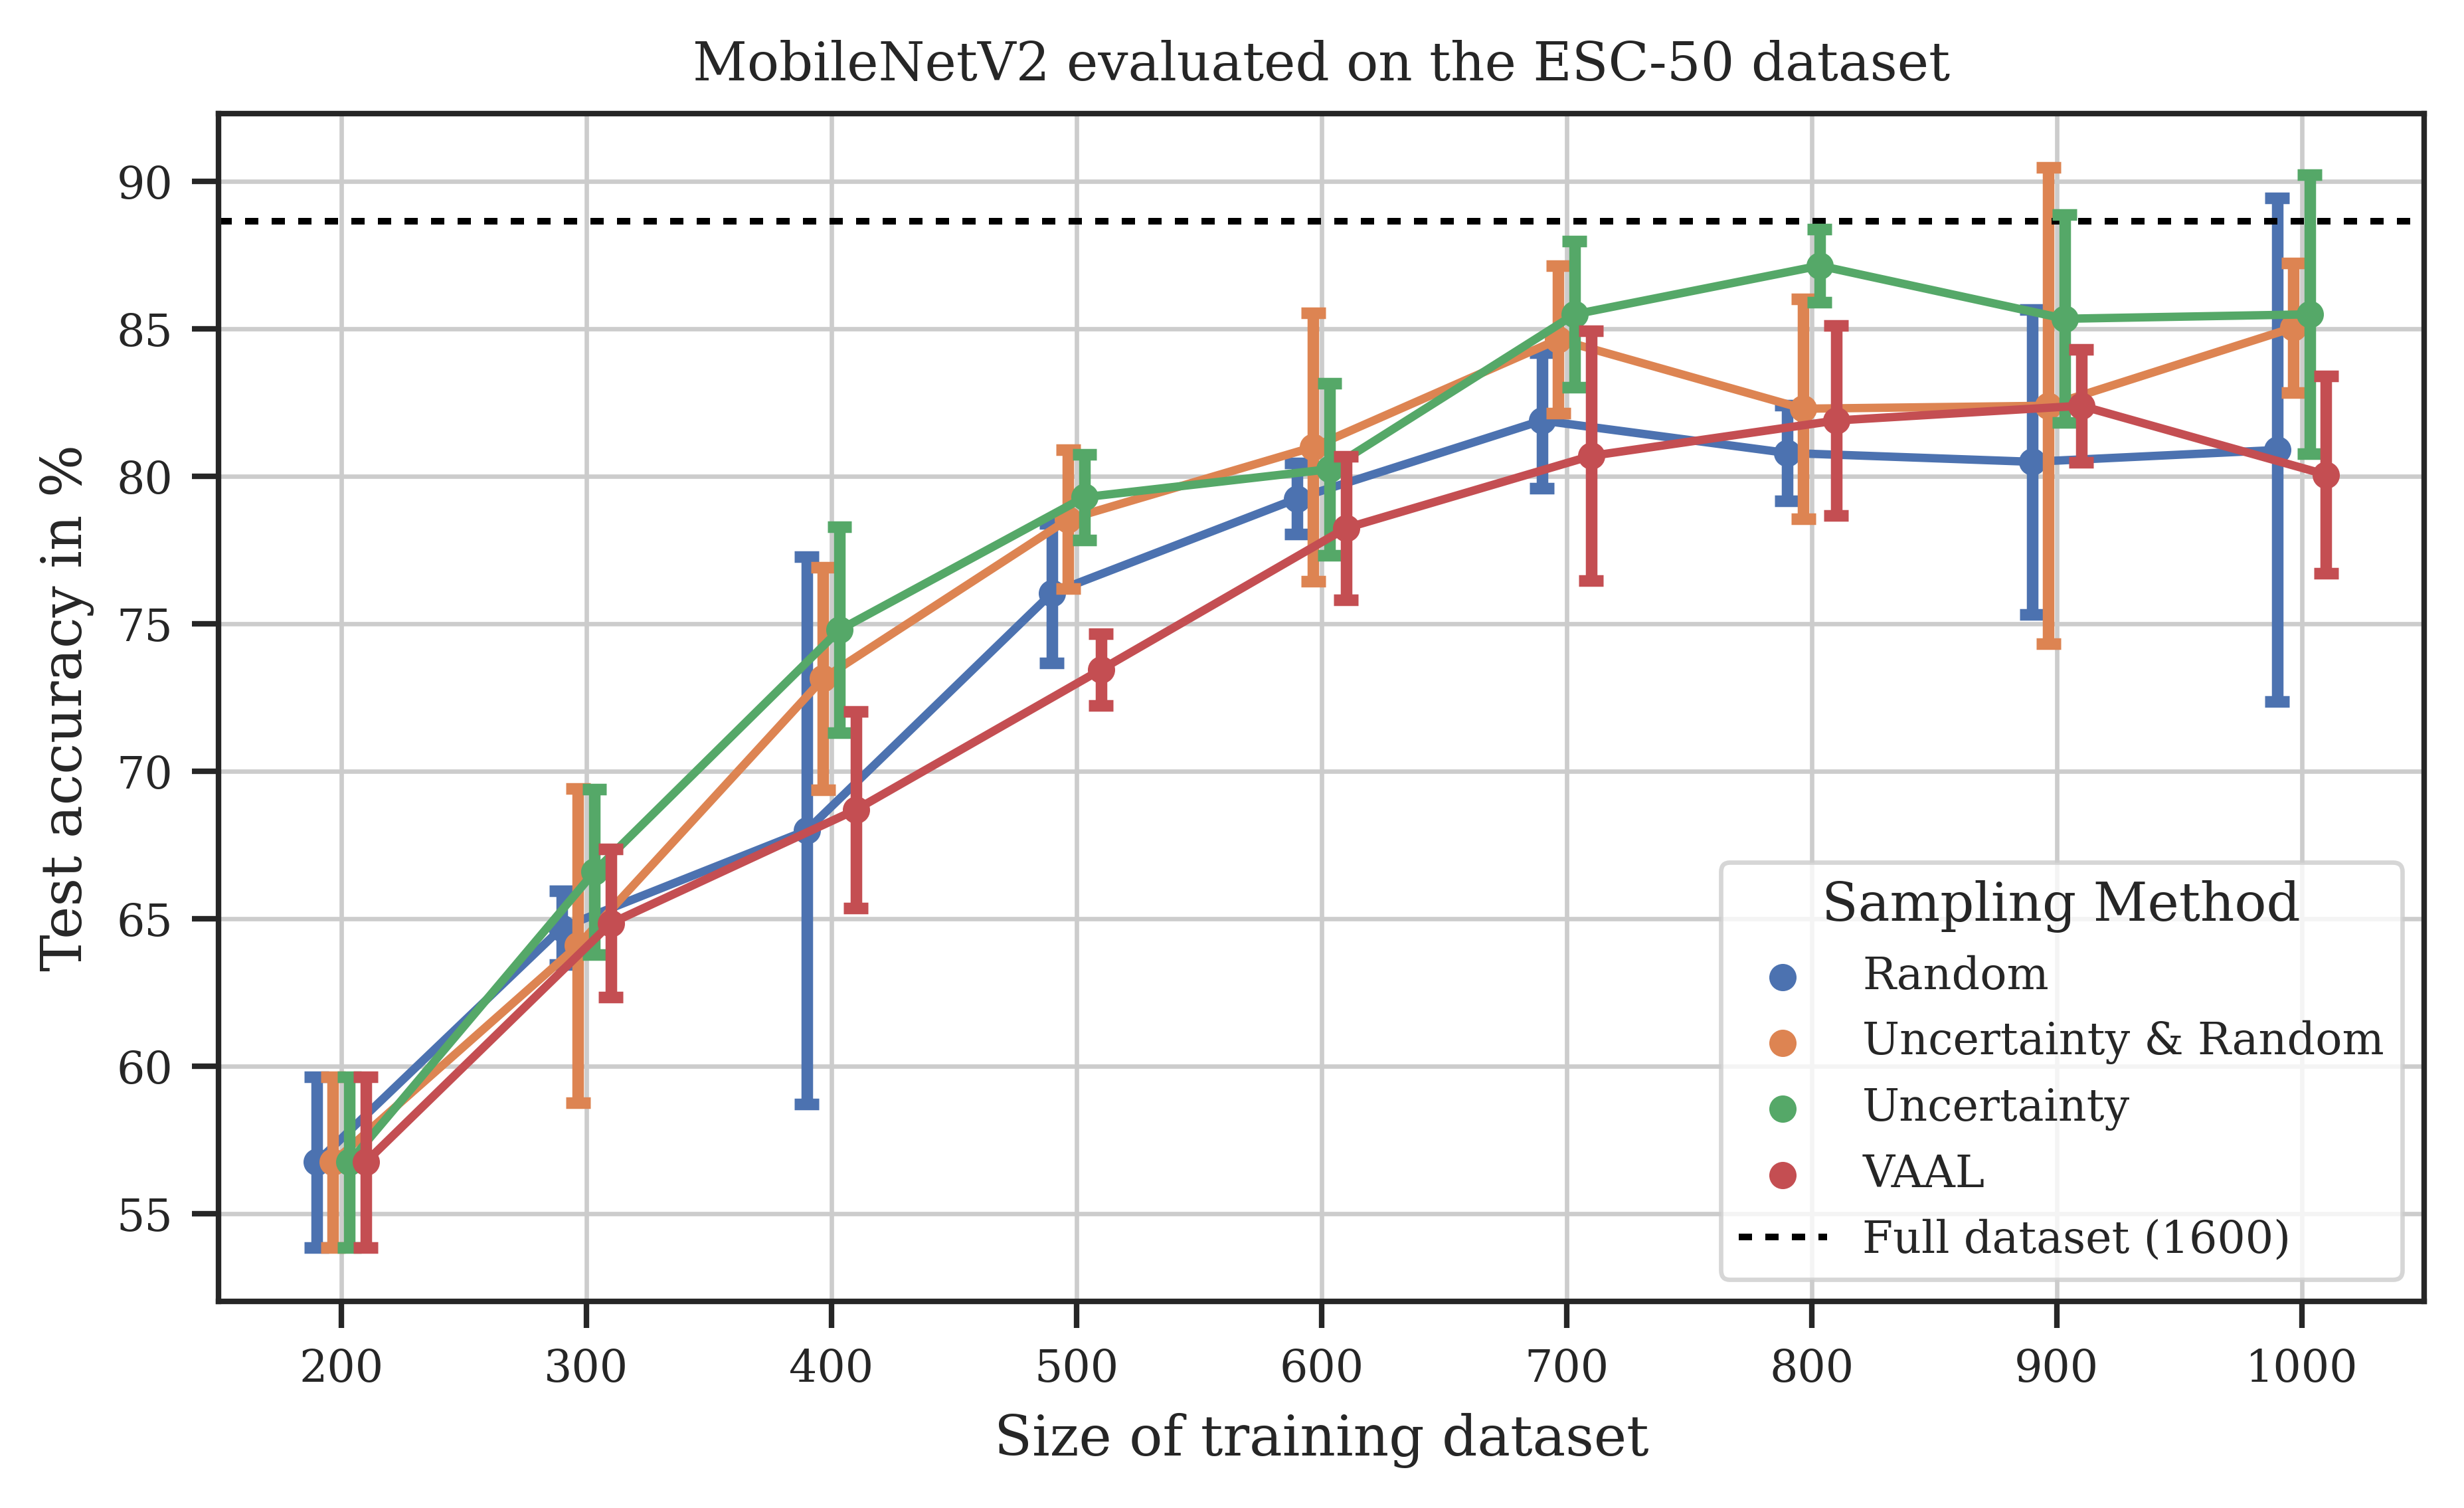

In [4]:
save_path = os.path.join("docs/results/ESC50")

full = find_csv(os.path.join(save_path, "1600"))
full_df = concat_results(full, save_path)

dfs = find_csv(os.path.join(save_path, "runs"))


df = concat_results(dfs, save_path)
df = add_last_and_best(df, save_path)
df = df[df["last_model"] == True]

set_style()
linewidth = 0.7

order=['Random', 'Uncertain+Random', 'Uncertainty', 'VAAL']
al_labels=['Random', 'Uncertainty & Random', 'Uncertainty', 'VAAL', "Full dataset (1600)"]

plt.figure(figsize=(set_size("project", fraction=1)))
g = sns.pointplot(
    data=df,
    x="train_size",
    y="test_acc",
    errorbar=("se", 2),
    hue="ActiveLearn",
    scale=linewidth,
    errwidth=linewidth * 3,
    capsize=0.1,
    dodge=0.2,
    hue_order=order
)
g.set(
    # title="Test accuracies over train size",
    xlabel="Size of training dataset",
    ylabel="Test accuracy in %",
)

full_df = add_last_and_best(full_df)
full = full_df[full_df["last_model"] == True]
full_mean = full.test_acc.mean()
g.axhline(full_mean, label="Full dataset", dashes=[2, 2], color="black")
handles, labels = g.get_legend_handles_labels()
plt.title("MobileNetV2 evaluated on the ESC-50 dataset")
plt.grid(True)
plt.legend(handles=handles, labels=al_labels, title="Sampling Method")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ESC-50.png"))
plt.savefig(os.path.join(save_path, "ESC-50.eps"))
plt.show()

In [38]:
save_path
full["ActiveLearn"] = "Full dataset acc."
new = pd.concat([df, full], axis=0)
new

/tmp/ipykernel_9434/554523784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full["ActiveLearn"] = "Full dataset acc."


,train_loss,test_loss,train_acc,test_acc,epoch,lr,weight_decay,params_acc,last_model,current_indices,TaskLearner,ActiveLearn,train_size,pool_size,n,Unnamed: 0,best_model
149,3.029695,3.256216,92.333333,70.50,150,0.0002,0.00010,0.815556,True,"[4, 487, 1507, 1487, 108, 798, 1363, 1120, 526...",MobileNet,Random,900,700,0,NaN,0
426,2.922631,3.109766,99.200000,88.25,277,0.0001,0.00010,0.809000,True,"[4, 487, 1507, 1487, 108, 798, 1363, 1120, 526...",MobileNet,Random,1000,600,0,NaN,0
726,2.828140,3.270803,96.000000,71.50,300,0.0002,0.00001,0.526667,True,"[356, 115, 1134, 178, 1090, 1324, 676, 1416, 6...",MobileNet,Uncertainty,300,1300,3,NaN,0
861,2.828324,3.287108,96.000000,74.00,135,0.0002,0.00010,0.555000,True,"[356, 115, 1134, 178, 1090, 1324, 676, 1416, 6...",MobileNet,Uncertainty,400,1200,3,NaN,0
1040,2.828230,3.214450,96.000000,81.75,179,0.0002,0.00005,0.576000,True,"[356, 115, 1134, 178, 1090, 1324, 676, 1416, 6...",MobileNet,Uncertainty,500,1100,3,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2.946389,3.068016,100.000000,90.00,197,0.0001,0.00010,0.876875,True,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",MobileNet,Full dataset acc.,1600,0,0,NaN,0
427,2.948976,3.057984,99.937500,91.25,231,0.0001,0.00010,0.891250,True,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",MobileNet,Full dataset acc.,1600,0,3,NaN,0
590,2.946763,3.069480,100.000000,90.00,163,0.0001,0.00010,0.878750,True,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",MobileNet,Full dataset acc.,1600,0,4,NaN,0
709,2.960282,3.109053,99.187500,84.25,119,0.0002,0.00005,0.893750,True,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",MobileNet,Full dataset acc.,1600,0,2,NaN,0


In [39]:
def make_latex(save_path, df):
    df_mean=df.groupby(['ActiveLearn', 'train_size']).mean()['test_acc']
    df_mean=df_mean.round(3)
    df_sem=df.groupby(['ActiveLearn', 'train_size']).sem()['test_acc']*2
    df_sem = df_sem.round(3)
    #df_lr=df.groupby(['ActiveLearn', 'train_size'])['lr'].apply(list)
    #df_weight_decay=df.groupby(['ActiveLearn', 'train_size'])['weight_decay'].apply(list)

    df_stats = pd.concat([df_mean, df_sem], axis=1) #, df_lr, df_weight_decay
    df_stats.columns.values[0] = "Mean"
    df_stats.columns.values[1] = "CI 95"
    #df_stats.columns.values[2] = "Learning rates"
    #df_stats.columns.values[3] = "Weight decays"
    df_stats.index.names = ['Sampling', 'Train Size']
    df_stats = df_stats.rename(index={'Uncertain+Random': 'Unc. & ran.'})
    with open(save_path, 'w') as tf:
         tf.write(df_stats.to_latex())

make_latex(os.path.join(save_path, "ESC50/WSA1K.tex"), new)

/tmp/ipykernel_9434/2487979748.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df_stats.to_latex())
